In [60]:
# Manejo de datos
import numpy as np
import pandas as pd

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Manejo de archivos
import os
from pathlib import Path

# Detección de outliers...
from pyod.models.iforest import IForest

# Valores perdidos...
import missingno as msno

# Importancia de características...
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Cargar los datos:

In [61]:
processed_folder = Path.cwd().parent / 'data' / 'processed'
df = pd.read_parquet(processed_folder / "df_model_tidy.parquet")
df

,velocidad,potencia,rendimiento,ruido,p80,f80,per_solidos,wi,spi,imp_criticos,imp_estandares,jb,presion
date,,,,,,,,,,,,,
2022-11-15 00:00:00,NaN,38829.984689,NaN,15.788181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.045367,88.832868
2022-11-15 00:00:10,NaN,38801.377137,NaN,15.428343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043414,89.271139
2022-11-15 00:00:20,NaN,38168.832363,NaN,15.428343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.041364,89.849212
2022-11-15 00:00:30,NaN,39007.987239,NaN,14.517244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.039330,89.613041
2022-11-15 00:00:40,NaN,38731.447564,NaN,14.517244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.037073,89.520688
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-14 23:59:20,75.494482,41194.875702,71.307249,8.845677,26.446656,45.849870,77.265464,92.573475,38.54322,0.900937,32.153835,89.318678,89.175128
2022-12-14 23:59:30,75.496079,41194.875702,71.403265,8.845677,26.446656,45.931528,77.298097,92.573475,38.54322,0.899591,32.294106,89.318678,89.175128
2022-12-14 23:59:40,75.497677,40686.296989,71.458539,8.845677,26.446656,46.134072,77.327109,92.573475,38.54322,0.898244,32.434377,89.314536,89.181349


# Iniciando exploración de los datos...

In [62]:
df.shape

(259201, 13)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 259201 entries, 2022-11-15 00:00:00 to 2022-12-15 00:00:00
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   velocidad       248682 non-null  float64
 1   potencia        251649 non-null  float64
 2   rendimiento     248682 non-null  float64
 3   ruido           251649 non-null  float64
 4   p80             248682 non-null  float64
 5   f80             248682 non-null  float64
 6   per_solidos     248682 non-null  float64
 7   wi              248682 non-null  float64
 8   spi             248682 non-null  float64
 9   imp_criticos    248682 non-null  float64
 10  imp_estandares  248682 non-null  float64
 11  jb              251649 non-null  float64
 12  presion         251649 non-null  float64
dtypes: float64(13)
memory usage: 27.7 MB


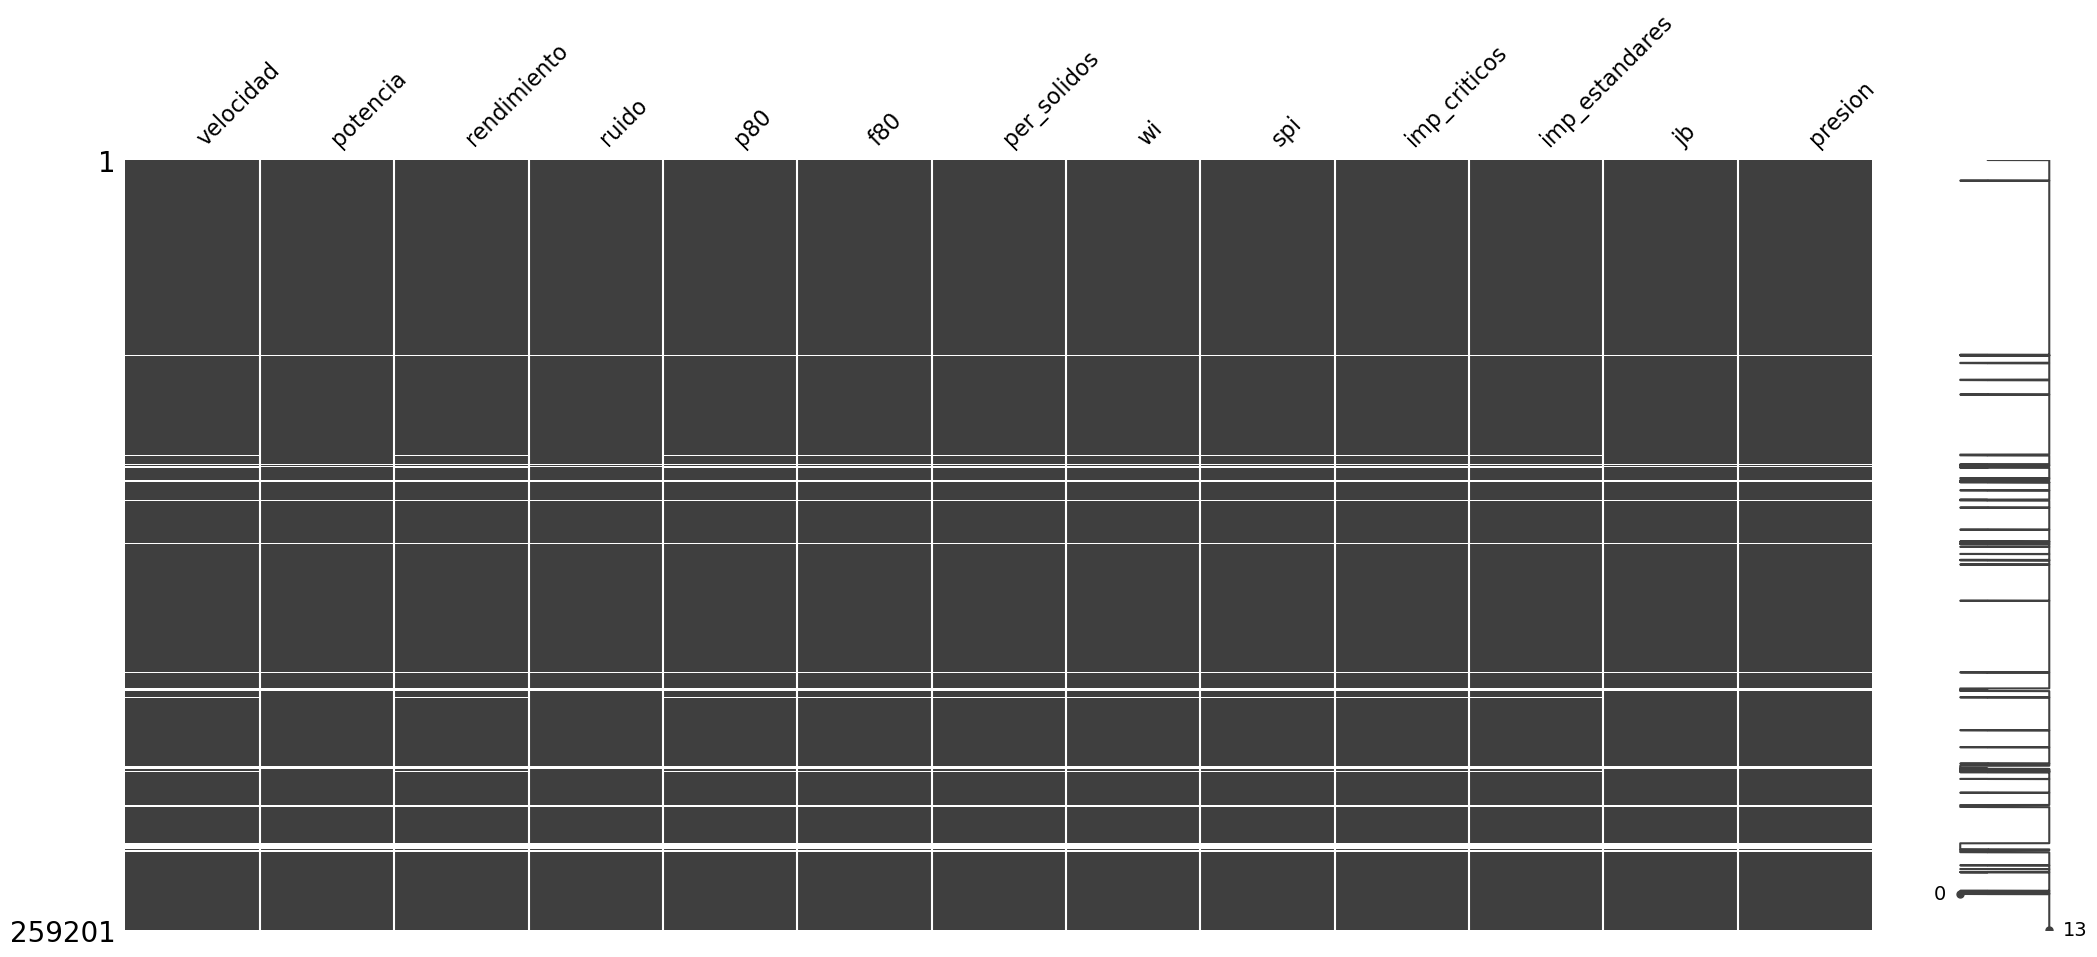

In [64]:
msno.matrix(df);

In [65]:
df.dropna(inplace = True, axis = 0)
df.shape

(248682, 13)

In [66]:
df.describe()

,velocidad,potencia,rendimiento,ruido,p80,f80,per_solidos,wi,spi,imp_criticos,imp_estandares,jb,presion
count,248682.000000,248682.000000,248682.000000,248682.000000,248682.000000,248682.000000,248682.000000,248682.000000,248682.000000,248682.000000,248682.000000,248682.000000,248682.000000
mean,69.987282,37194.399997,59.481675,10.219533,44.530868,38.834566,75.152336,91.972865,50.644520,2.077076,40.909125,44.975471,88.514296
std,6.245386,4255.840709,8.292144,5.214604,17.229162,13.591591,3.211313,11.867715,14.978864,2.405439,22.225558,29.561228,3.512846
min,48.266666,21125.088265,24.500046,0.000000,0.000000,10.703177,50.338806,0.000000,0.000000,0.000000,0.021956,1.238072,68.339688
25%,65.782897,34700.961268,55.825822,6.180227,31.130319,28.895761,73.733003,94.225297,43.714228,0.228938,21.748451,20.771192,86.227242
50%,72.233312,38372.263848,61.401723,10.430614,44.740149,37.053784,75.859680,94.916176,50.585868,1.213370,45.668057,33.426770,88.462281
75%,75.737066,40374.792528,64.927461,13.526586,55.344245,47.961317,77.682332,95.619150,58.419725,3.241489,59.584797,78.559692,90.859836
max,75.820134,45390.650079,75.371860,49.926609,100.000000,91.966382,81.595704,100.000000,100.000000,62.633323,91.597141,100.000000,100.000000


In [67]:
#Buscando atributo con valores constantes (desv stad ==0)
for columna in df.columns:
  if df[columna].std()==0.0:
    print(columna)

In [68]:
# Buscar valores negativos... Outliers...
for columna in df.columns:
  numOutliers = 0
  for i in range(df.shape[0]):
    if df[columna][i]<0:
      numOutliers = numOutliers + 1

  if numOutliers>0:
    print(columna, numOutliers)

In [69]:
# Eliminar duplicados si habían duplicados...
df_sd = df.drop_duplicates()

if df_sd.shape == df.shape:
    print("No hubo duplicados...")
else:
    df = df_sd
    print("Duplicados eliminados, DF listo...")

No hubo duplicados...


# Detección de Outliers...

Outliers... en series de tiempo...

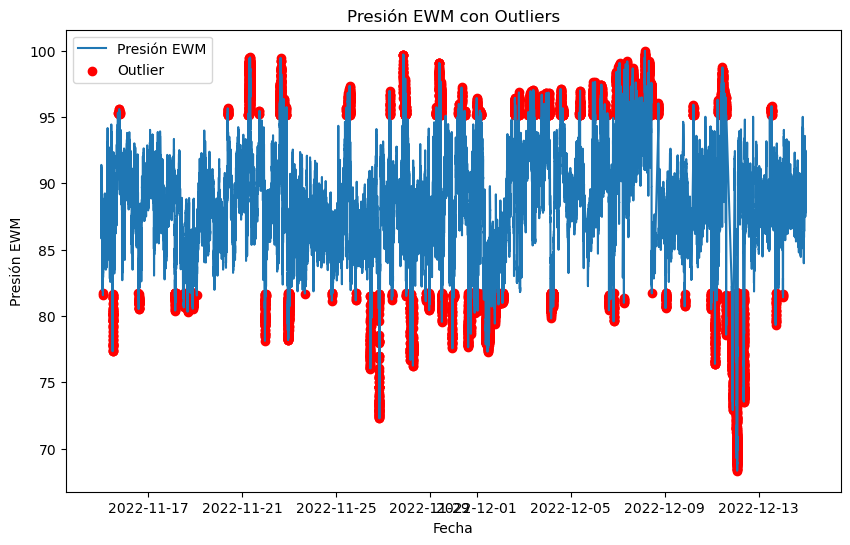

Outliers detectados:
                     velocidad      potencia  rendimiento      ruido  \
date                                                                   
2022-11-15 01:56:50  67.618293  33715.590013    68.212216  14.421127   
2022-11-15 01:57:20  67.498599  33079.866622    68.220688  14.255947   
2022-11-15 11:45:50  74.026470  34230.525959    49.080206  24.795404   
2022-11-15 11:46:00  73.917958  34230.525959    48.720423  24.795404   
2022-11-15 11:46:10  73.771145  33308.727043    48.423563  25.664504   
...                        ...           ...          ...        ...   
2022-12-13 17:21:10  67.878370  32978.150880    57.297457   8.058155   
2022-12-14 00:52:10  52.411399  25962.943266    36.106223  10.430614   
2022-12-14 00:52:20  52.385859  25962.943266    36.367048   9.363019   
2022-12-14 00:52:30  52.360318  25962.943266    36.729155   9.519515   
2022-12-14 00:52:40  52.334778  25962.943266    37.004364   9.519515   

                           p80        f80 

In [70]:
# Detectar Outlayer usando pyOD... 

# Extraer los precios
presion = df['presion'].values.reshape(-1, 1)

# Inicializar el modelo de Isolation Forest
model = IForest(contamination=0.05)
model.fit(presion)

# Predecir outliers
df['Outlier'] = model.predict(presion)

# Visualizar los resultados
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['presion'], label='Presión EWM')
plt.scatter(df.index[df['Outlier'] == 1], df['presion'][df['Outlier'] == 1], 
            color='red', label='Outlier', marker='o')
plt.xlabel('Fecha')
plt.ylabel('Presión EWM')
plt.title('Presión EWM con Outliers')
plt.legend()
plt.show()

# Imprimir los outliers detectados
outliers = df[df['Outlier'] == 1]
print("Outliers detectados:")
print(outliers)

In [71]:
df = df.drop("Outlier", axis = 1)

Valorar si revisar Outliers solo de la variable objetivo o de las demás también...

# Visualizar todo el set de datos...

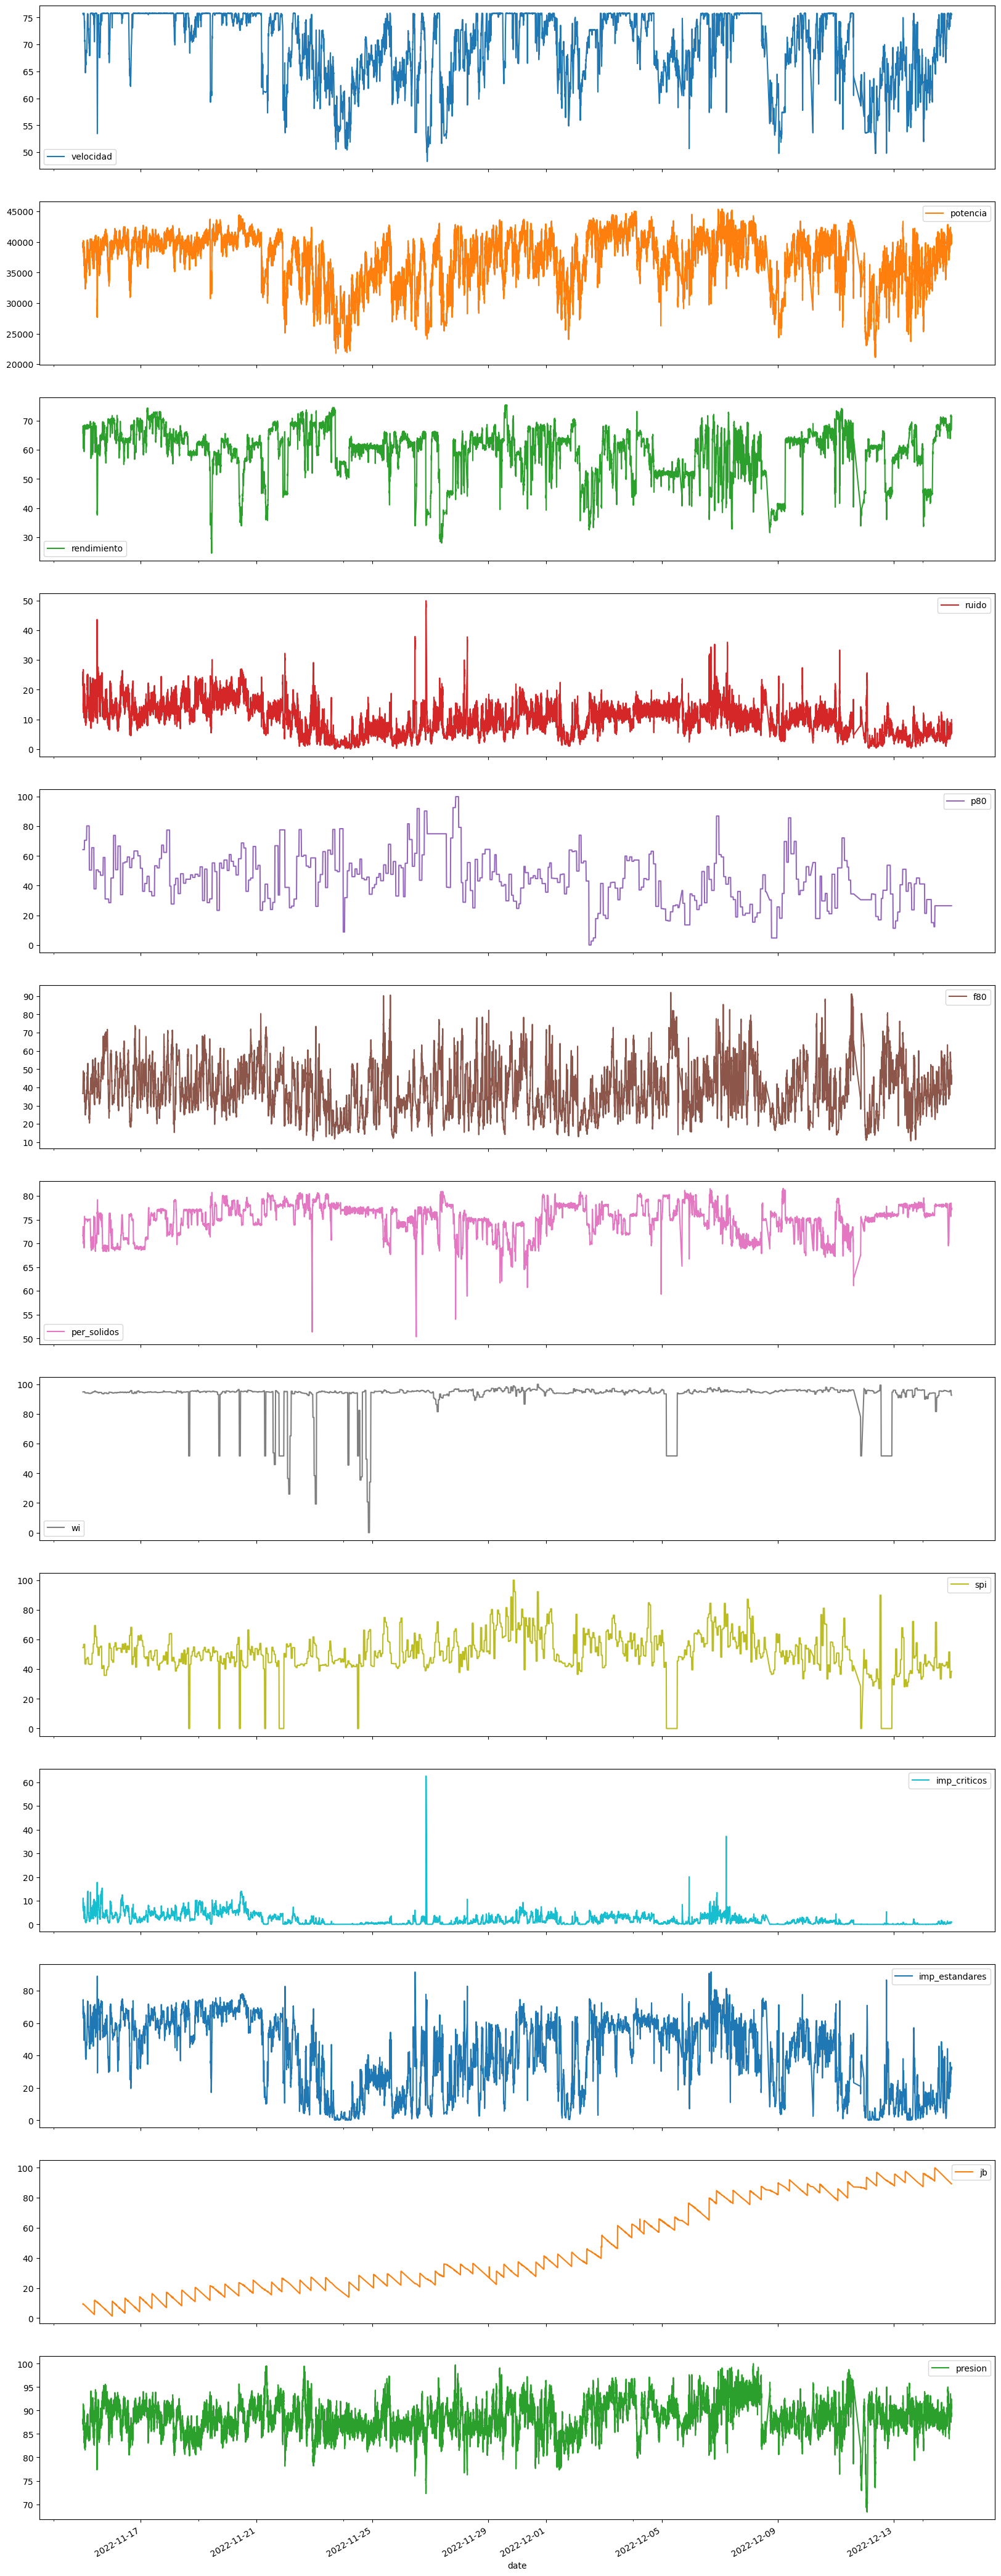

In [72]:
# Para visualizar todo el set de datos...

# Columnas del dataset...
cols = df.columns

# Dibujar la totalidad de registros...
N = df.shape[0]       # Número de registros...
plots = df[cols][0:N] # Series de tiempo individuales...
plots.index = df.index[0:N] # Variable tiempo...
_ = plots.plot(subplots=True, figsize=(20,60))

# Revisando la periodicidad de los datos...

In [73]:
# Análisis de la periodicidad del dataset...
df_time_diffs = df.index.to_series().diff().dt.total_seconds()
print(df_time_diffs.value_counts())

date
10.0       248628
520.0           6
490.0           5
550.0           4
560.0           3
500.0           3
720.0           2
540.0           2
530.0           2
790.0           2
7070.0          1
20530.0         1
7050.0          1
8880.0          1
1040.0          1
1940.0          1
1090.0          1
10550.0         1
640.0           1
680.0           1
510.0           1
670.0           1
1180.0          1
1510.0          1
750.0           1
3570.0          1
650.0           1
5410.0          1
5040.0          1
2420.0          1
3310.0          1
2090.0          1
1740.0          1
820.0           1
Name: count, dtype: int64


In [74]:
# Resampleo a una frecuencia de 10 segundos
df_resampled = df.resample('10S').mean()

# Interpolación para llenar valores faltantes creados por el re-sampleo
df_resampled = df_resampled.interpolate(method='time')

# Verificar los datos re-sampleados
df_resampled

,velocidad,potencia,rendimiento,ruido,p80,f80,per_solidos,wi,spi,imp_criticos,imp_estandares,jb,presion
date,,,,,,,,,,,,,
2022-11-15 00:07:50,75.761029,39281.348296,65.653747,22.932414,64.260113,36.574719,71.583049,94.815049,54.50695,7.101110,65.598165,9.183127,87.199926
2022-11-15 00:08:00,75.761029,39850.320731,65.691489,22.932414,64.260113,36.555098,71.579590,94.815049,54.50695,7.191338,65.798205,9.180693,87.402467
2022-11-15 00:08:10,75.761029,39761.319456,65.783858,21.329909,64.260113,36.535478,71.585002,94.815049,54.50695,7.281566,65.998244,9.178803,87.492231
2022-11-15 00:08:20,75.761029,39761.319456,65.906084,21.329909,64.260113,36.515857,71.598714,94.815049,54.50695,7.371795,66.198283,9.178803,87.492231
2022-11-15 00:08:30,75.761029,39665.960948,65.986245,22.538648,64.260113,36.583533,71.615886,94.815049,54.50695,7.462023,66.398322,9.174560,87.564041
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-14 23:59:20,75.494482,41194.875702,71.307249,8.845677,26.446656,45.849870,77.265464,92.573475,38.54322,0.900937,32.153835,89.318678,89.175128
2022-12-14 23:59:30,75.496079,41194.875702,71.403265,8.845677,26.446656,45.931528,77.298097,92.573475,38.54322,0.899591,32.294106,89.318678,89.175128
2022-12-14 23:59:40,75.497677,40686.296989,71.458539,8.845677,26.446656,46.134072,77.327109,92.573475,38.54322,0.898244,32.434377,89.314536,89.181349


# Importancia de las características v2

In [75]:
# Preparando los datos...
X = df_resampled.drop("presion", axis = 1)
y = df_resampled["presion"]

In [76]:
# Escalando las características del conjunto de datos X...
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Regresión lineal... Método Lasso...

In [77]:
# Determinando el mejor alpha para este modelo...
alphas = [0.001, 0.01, 0.1, 1, 10, 20, 100, 1000]
scores = []

for alpha in alphas:
    lasso = Lasso(alpha = alpha)
    lasso.fit(X_scaled, y)
    score = lasso.score(X_scaled, y)
    scores.append(score)

print(scores, np.argmax(scores))

[0.5407259208547655, 0.5405190623076847, 0.5267555822989769, 0.19803518957051702, 0.0, 0.0, 0.0, 0.0] 0


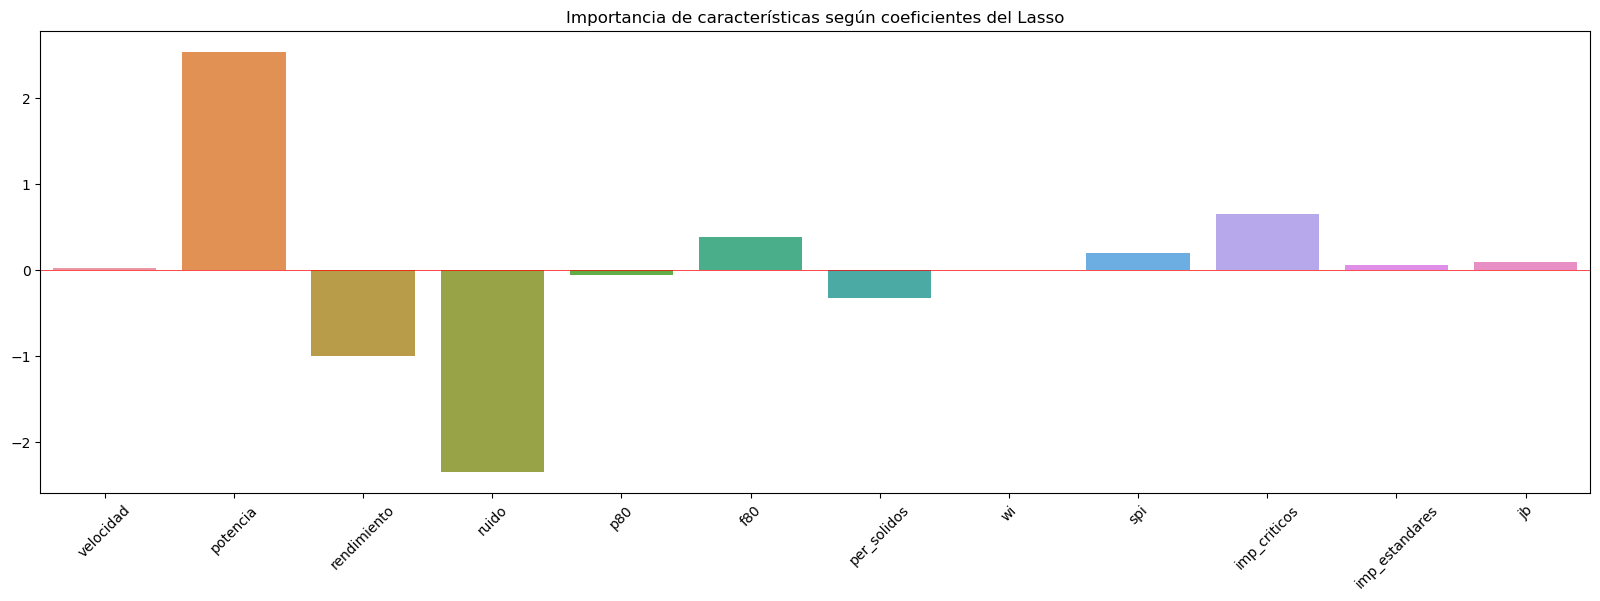

In [78]:
# Realizando la prueba...
lasso = Lasso(alpha = 0.001)
coef = lasso.fit(X_scaled, y).coef_

# Graficando...
plt.figure(figsize=(20, 6))
ax = sns.barplot(x = X.columns, y = coef)
plt.axhline(0, color = "red", linewidth = 0.5)
plt.xticks(rotation = 45)
plt.title("Importancia de características según coeficientes del Lasso")
plt.show()

Regresión lineal sin seleccionar características...

In [79]:
# Viendo que tal con una regresión lineal...

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = lasso.predict(X_test)

# Calcular R^2
r2 = r2_score(y_test, y_pred)

# Calcular MSE
mse = mean_squared_error(y_test, y_pred)

print("R^2:", r2)
print("MSE:", mse)

R^2: 0.5378009103400758
MSE: 5.804595845496744


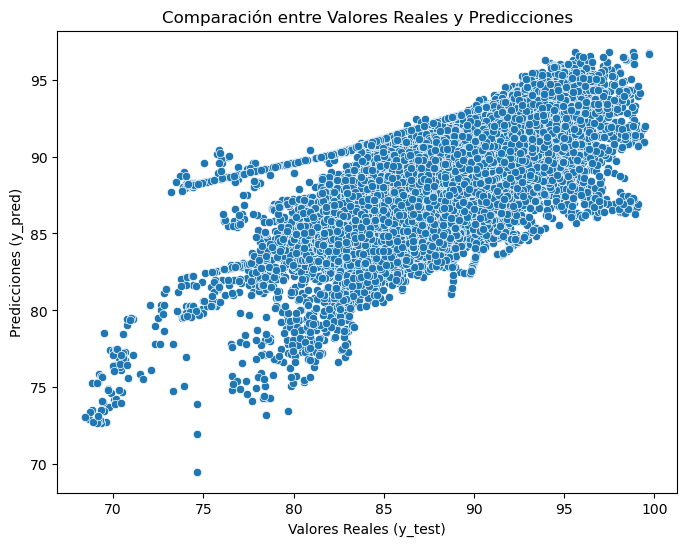

In [80]:
# Graficando...
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Valores Reales (y_test)')
plt.ylabel('Predicciones (y_pred)')
plt.title('Comparación entre Valores Reales y Predicciones')
plt.show()

Regresión lineal obviando características...

In [81]:
df_resampled

,velocidad,potencia,rendimiento,ruido,p80,f80,per_solidos,wi,spi,imp_criticos,imp_estandares,jb,presion
date,,,,,,,,,,,,,
2022-11-15 00:07:50,75.761029,39281.348296,65.653747,22.932414,64.260113,36.574719,71.583049,94.815049,54.50695,7.101110,65.598165,9.183127,87.199926
2022-11-15 00:08:00,75.761029,39850.320731,65.691489,22.932414,64.260113,36.555098,71.579590,94.815049,54.50695,7.191338,65.798205,9.180693,87.402467
2022-11-15 00:08:10,75.761029,39761.319456,65.783858,21.329909,64.260113,36.535478,71.585002,94.815049,54.50695,7.281566,65.998244,9.178803,87.492231
2022-11-15 00:08:20,75.761029,39761.319456,65.906084,21.329909,64.260113,36.515857,71.598714,94.815049,54.50695,7.371795,66.198283,9.178803,87.492231
2022-11-15 00:08:30,75.761029,39665.960948,65.986245,22.538648,64.260113,36.583533,71.615886,94.815049,54.50695,7.462023,66.398322,9.174560,87.564041
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-14 23:59:20,75.494482,41194.875702,71.307249,8.845677,26.446656,45.849870,77.265464,92.573475,38.54322,0.900937,32.153835,89.318678,89.175128
2022-12-14 23:59:30,75.496079,41194.875702,71.403265,8.845677,26.446656,45.931528,77.298097,92.573475,38.54322,0.899591,32.294106,89.318678,89.175128
2022-12-14 23:59:40,75.497677,40686.296989,71.458539,8.845677,26.446656,46.134072,77.327109,92.573475,38.54322,0.898244,32.434377,89.314536,89.181349


In [83]:
coef

array([ 2.76379673e-02,  2.53557855e+00, -9.94874615e-01, -2.34731865e+00,
       -5.54951112e-02,  3.91305259e-01, -3.26000774e-01, -1.96950387e-04,
        1.96606209e-01,  6.56767695e-01,  6.14999116e-02,  9.20454863e-02])

In [92]:
cols_drop = ['velocidad', 'p80', 'wi', 'imp_estandares', 'jb']

# Características finales con las que se correrá el modelo...
df_lasso = df_resampled.drop(cols_drop, axis = 1)
df_lasso

,potencia,rendimiento,ruido,f80,per_solidos,spi,imp_criticos,presion
date,,,,,,,,
2022-11-15 00:07:50,39281.348296,65.653747,22.932414,36.574719,71.583049,54.50695,7.101110,87.199926
2022-11-15 00:08:00,39850.320731,65.691489,22.932414,36.555098,71.579590,54.50695,7.191338,87.402467
2022-11-15 00:08:10,39761.319456,65.783858,21.329909,36.535478,71.585002,54.50695,7.281566,87.492231
2022-11-15 00:08:20,39761.319456,65.906084,21.329909,36.515857,71.598714,54.50695,7.371795,87.492231
2022-11-15 00:08:30,39665.960948,65.986245,22.538648,36.583533,71.615886,54.50695,7.462023,87.564041
...,...,...,...,...,...,...,...,...
2022-12-14 23:59:20,41194.875702,71.307249,8.845677,45.849870,77.265464,38.54322,0.900937,89.175128
2022-12-14 23:59:30,41194.875702,71.403265,8.845677,45.931528,77.298097,38.54322,0.899591,89.175128
2022-12-14 23:59:40,40686.296989,71.458539,8.845677,46.134072,77.327109,38.54322,0.898244,89.181349


In [93]:
df_lasso.to_parquet(processed_folder / "df_model_tidy_lasso.parquet")